# Employee Sentiment Analysis

This notebook performs comprehensive sentiment analysis on employee communication data including:
- Sentiment classification using TextBlob
- Exploratory data analysis with visualizations
- Monthly sentiment trends
- Employee scoring and ranking
- Flight risk detection
- Trend analysis using linear regression

## 1. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from datetime import timedelta

## 2. Load and Explore Dataset

In [3]:
# Load dataset
df = pd.read_excel('test.xlsx')
df['date'] = pd.to_datetime(df['date'])
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Subject  2191 non-null   object        
 1   body     2191 non-null   object        
 2   date     2191 non-null   datetime64[ns]
 3   from     2191 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 68.6+ KB
None
                                date
count                           2191
mean   2010-12-31 02:17:21.716111360
min              2010-01-01 00:00:00
25%              2010-06-30 12:00:00
50%              2011-01-01 00:00:00
75%              2011-06-30 12:00:00
max              2011-12-31 00:00:00
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4       

## 3. Sentiment Analysis Function and Labeling

In [4]:
# Define sentiment labeling function with neutral band
def get_sentiment(text, neutral_band=0.05):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > neutral_band:
        return 'Positive', polarity
    elif polarity < -neutral_band:
        return 'Negative', polarity
    else:
        return 'Neutral', polarity

# Apply sentiment analysis to combined subject and body text
df[['Sentiment', 'polarity']] = df['Subject'].fillna('').astype(str).add(" " + df['body'].fillna('').astype(str)).apply(
    lambda x: pd.Series(get_sentiment(x))
)

## 4. Exploratory Data Analysis (EDA)

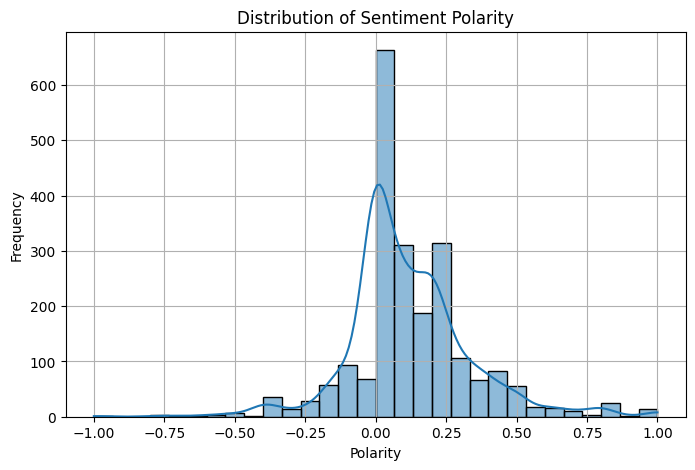

In [5]:
# Plot sentiment polarity distribution
plt.figure(figsize=(8,5))
sns.histplot(df['polarity'], bins=30, kde=True)
plt.title("Distribution of Sentiment Polarity")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

/tmp/ipython-input-1651783054.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment', data=df, palette="Set2")


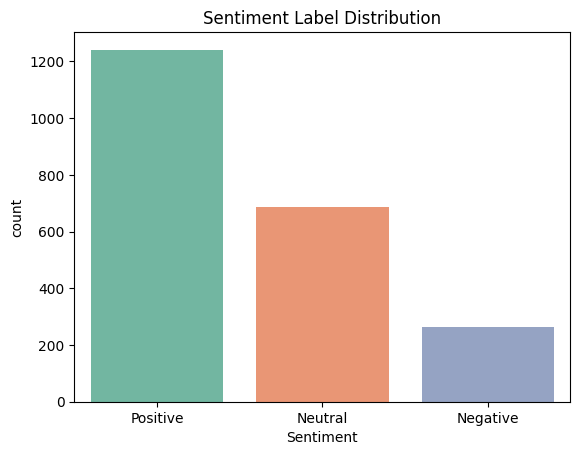

In [6]:
# Plot sentiment label distribution
sns.countplot(x='Sentiment', data=df, palette="Set2")
plt.title('Sentiment Label Distribution')
plt.show()

## 5. Monthly Sentiment Trends

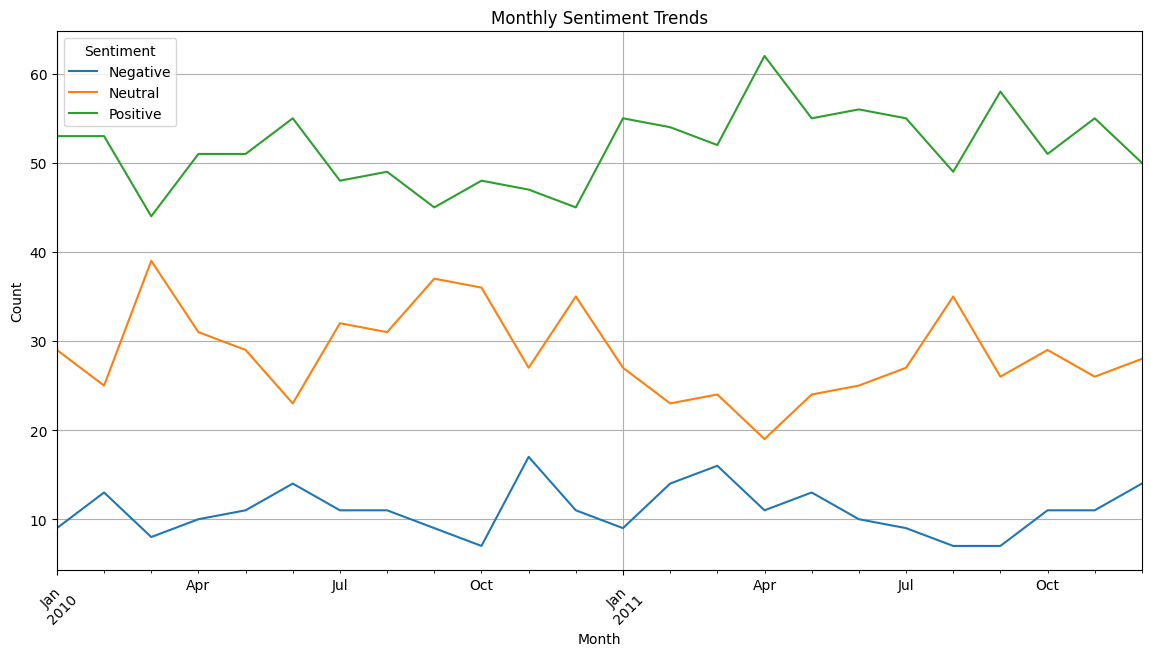

In [7]:
# Create monthly sentiment trends
df['month'] = df['date'].dt.to_period('M')
monthly_sentiment = df.groupby(['month', 'Sentiment']).size().unstack(fill_value=0)

# Plot monthly sentiment trends
monthly_sentiment.plot(kind='line', figsize=(14,7))
plt.title('Monthly Sentiment Trends')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.grid(True)
plt.show()

## 6. Monthly Employee Scoring and Ranking

In [8]:
# Create scoring system (+1/-1/0)
score_map = {"Positive": 1, "Negative": -1, "Neutral": 0}
df['score'] = df['Sentiment'].map(score_map)

# Calculate monthly scores per employee
monthly_scores = df.groupby(['from','month'])['score'].sum().reset_index()
monthly_scores.rename(columns={'from':'Employee','month':'Month','score':'MonthlyScore'}, inplace=True)

In [9]:
# Find top 3 positive & negative employees per month
top3_positive, top3_negative = [], []
for m, sub in monthly_scores.groupby('Month'):
    sub_pos = sub.sort_values(['MonthlyScore','Employee'], ascending=[False, True]).head(3)
    sub_neg = sub.sort_values(['MonthlyScore','Employee'], ascending=[True, True]).head(3)
    top3_positive.append(sub_pos.assign(Month=m))
    top3_negative.append(sub_neg.assign(Month=m))

top3_positive = pd.concat(top3_positive).reset_index(drop=True)
top3_negative = pd.concat(top3_negative).reset_index(drop=True)

print("\n--- Top 3 Positive Employees per Month ---")
print(top3_positive)
print("\n--- Top 3 Negative Employees per Month ---")
print(top3_negative)


--- Top 3 Positive Employees per Month ---
                       Employee    Month  MonthlyScore
0       kayne.coulter@enron.com  2010-01            12
1        don.baughman@enron.com  2010-01             6
2           eric.bass@enron.com  2010-01             6
3   bobette.riner@ipgdirect.com  2010-02            10
4        don.baughman@enron.com  2010-02             7
..                          ...      ...           ...
67  bobette.riner@ipgdirect.com  2011-11             8
68      kayne.coulter@enron.com  2011-11             8
69      kayne.coulter@enron.com  2011-12             6
70     patti.thompson@enron.com  2011-12             6
71      rhonda.denton@enron.com  2011-12             5

[72 rows x 3 columns]

--- Top 3 Negative Employees per Month ---
                       Employee    Month  MonthlyScore
0       rhonda.denton@enron.com  2010-01             0
1   bobette.riner@ipgdirect.com  2010-01             2
2       johnny.palmer@enron.com  2010-01             2
3        

## 7. Flight Risk Detection

In [10]:
# Detect employees with ≥4 negative sentiments in rolling 30-day window
neg = df[df['Sentiment']=="Negative"].copy()
flight_risk_employees = set()

for emp, sub in neg.groupby('from'):
    sub = sub.sort_values('date')
    dates = sub['date'].tolist()
    i = 0
    for j in range(len(dates)):
        while i <= j and (dates[j] - dates[i]) > timedelta(days=30):
            i += 1
        if (j - i + 1) >= 4:
            flight_risk_employees.add(emp)
            break

print(f"\n--- Flight Risk Employees (≥4 negatives in rolling 30 days): {sorted(flight_risk_employees)}")


--- Flight Risk Employees (≥4 negatives in rolling 30 days): ['bobette.riner@ipgdirect.com', 'don.baughman@enron.com', 'eric.bass@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


## 8. Sentiment Trend Analysis with Linear Regression

In [11]:
# Prepare data for linear regression
monthly_polarity = df.groupby('month')['polarity'].mean().reset_index()
monthly_polarity['month_start'] = monthly_polarity['month'].dt.to_timestamp()
monthly_polarity['month_ordinal'] = monthly_polarity['month_start'].apply(lambda x: x.toordinal())

X = monthly_polarity[['month_ordinal']].values
y = monthly_polarity['polarity'].values


--- Linear Regression Model ---
Equation: polarity = 0.000049 * month_ordinal + -35.833012
R² score: 0.273


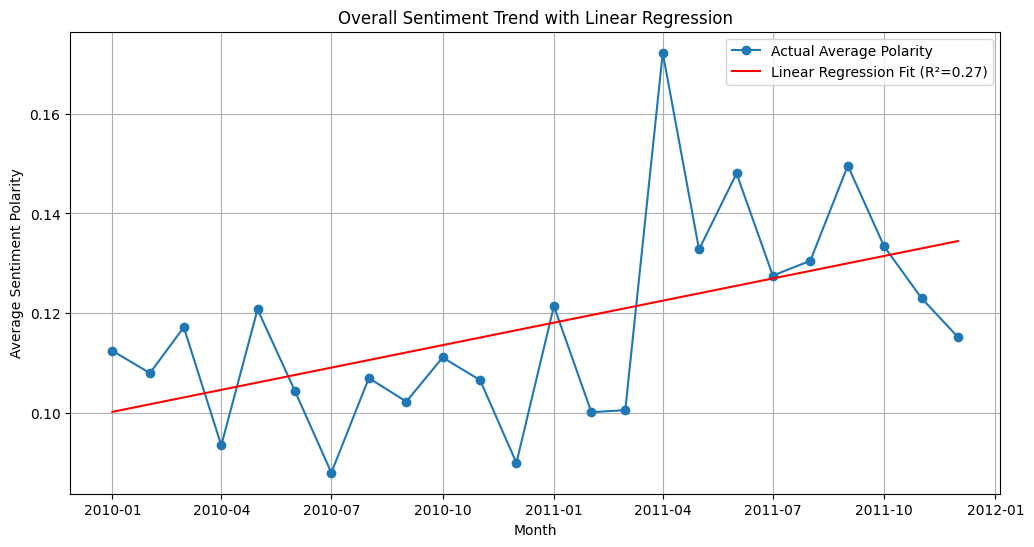

In [12]:
# Fit linear regression model and visualize
if len(monthly_polarity) >= 2:
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = r2_score(y, y_pred)

    print("\n--- Linear Regression Model ---")
    print(f"Equation: polarity = {slope:.6f} * month_ordinal + {intercept:.6f}")
    print(f"R² score: {r2:.3f}")

    plt.figure(figsize=(12,6))
    plt.plot(monthly_polarity['month_start'], y, marker='o', label='Actual Average Polarity')
    plt.plot(monthly_polarity['month_start'], y_pred, color='red', label=f'Linear Regression Fit (R²={r2:.2f})')
    plt.xlabel('Month')
    plt.ylabel('Average Sentiment Polarity')
    plt.title('Overall Sentiment Trend with Linear Regression')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\nNot enough data points for regression.")